
# Train a Stardist model from scratch with a pre-trained encoder

This example shows how to use cellseg_models.pytorch for training a Stardist model for instance segmentation with pytorch lightning along with the datasets and tools provided by the library.

In [ ]:
# !pip install cellseg_models.pytorch
# !pip install pytorch-lightning==1.5.4

## Download data

First, we will download some nuclei segmentation data. We will use the [Pannuke](https://jgamper.github.io/PanNukeDataset/) dataset by Gamper et al. The Pannuke dataset is split into three folds. We will use the first fold as training data, second as validation and the third as testing data.

Since we will train the [Stardist](https://github.com/stardist/stardist) model, we need to define the right nuclei instance transformations for training time. For Stardist, we define `"stardist"` and `"dist"` transformations. `"stardist"` transforms the labelled instance masks into radial distance maps and `"dist"` transforms the labelled instance masks into regular distance transformation maps. We also set `n_rays=32` to get 32 radial distance maps from the `"stardist"` transform.

Besides the instance mask transformations, we will also set `"blur"` and `"hue_sat"` (hue saturation) transformations and `"percentile"` normalization for the input images.

In [2]:
import pytorch_lightning as pl
import cellseg_models_pytorch as csmp
from pathlib import Path

fold_split = {"train": 1, "valid": 2, "test": 3}
save_dir = Path.home() / "pannuke" # modify the save path
pannuke_module = csmp.datamodules.PannukeDataModule(
    save_dir=save_dir,
    fold_split=fold_split,
    inst_transforms=["dist", "stardist"],
    img_transforms=["blur", "hue_sat"],
    normalization="percentile",
    n_rays=32
)

pannuke_module.prepare_data() # download and process the pannuke data

Found all folds. Skip downloading.
Found processed pannuke data. If in need of a re-download, please empty the `save_dir` folder.


**Let's visualize some Pannuke samples**

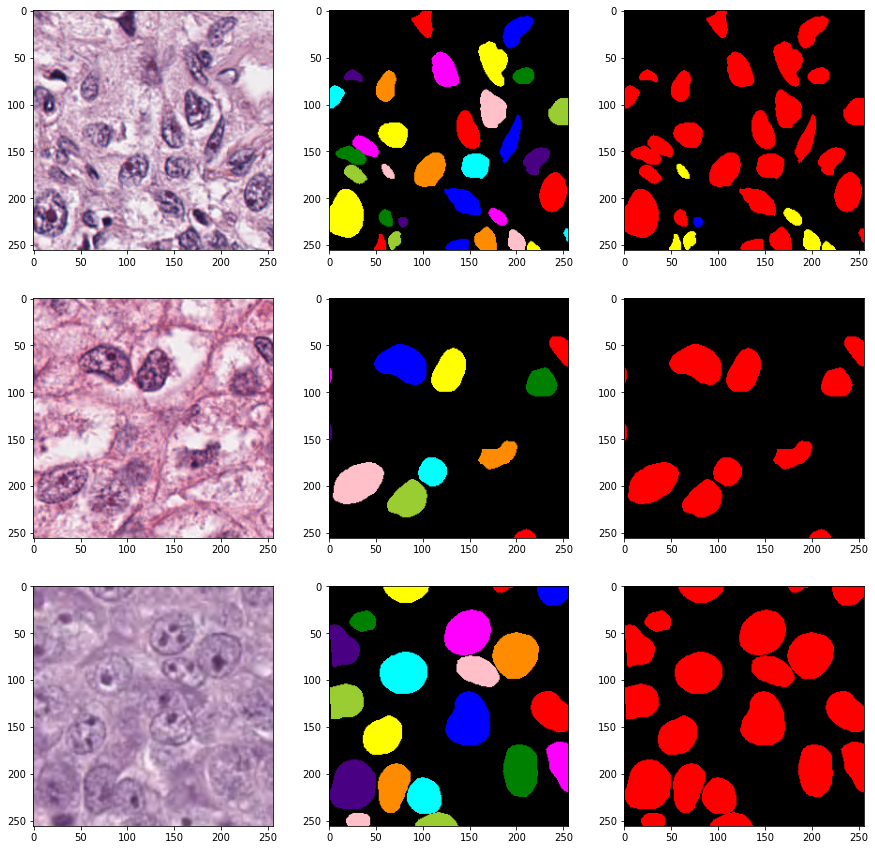

In [3]:
import matplotlib.pyplot as plt
from skimage.color import label2rgb

img_dir = save_dir / "train" / "images"
mask_dir = save_dir / "train" / "labels"
imgs = sorted(img_dir.glob("*"))
masks = sorted(mask_dir.glob("*"))

im1 = csmp.utils.FileHandler.read_img(imgs[0])
im2 = csmp.utils.FileHandler.read_img(imgs[50])
im3 = csmp.utils.FileHandler.read_img(imgs[500])
mask1 = csmp.utils.FileHandler.read_mask(masks[0], return_all=True)
mask2 = csmp.utils.FileHandler.read_mask(masks[50], return_all=True)
mask3 = csmp.utils.FileHandler.read_mask(masks[500], return_all=True)

fig, ax = plt.subplots(3, 3, figsize=(15, 15))
ax = ax.flatten()
ax[0].imshow(im1)
ax[1].imshow(label2rgb(mask1["inst_map"], bg_label=0))
ax[2].imshow(label2rgb(mask1["type_map"], bg_label=0))
ax[3].imshow(im2)
ax[4].imshow(label2rgb(mask2["inst_map"], bg_label=0))
ax[5].imshow(label2rgb(mask2["type_map"], bg_label=0))
ax[6].imshow(im3)
ax[7].imshow(label2rgb(mask3["inst_map"], bg_label=0))
ax[8].imshow(label2rgb(mask3["type_map"], bg_label=0))


## Training

First, we will define the multiclass Stardist nuclei segmentation model with a `imagenet` pre-trained `resnet50` backbone. Again, we set `n_rays=32`.

In [4]:
# Define the model with the function API. 
model = csmp.models.stardist_base_multiclass(
    enc_name="resnet50",
    n_rays=32,
    type_classes=len(pannuke_module.type_classes),
)

Next, we will define a `SegmentationExperiment`. It is a `pytorch.LightningModule` wrapper that encapsulates everything needed for training the model. 

For each output of the model, we define a joint-loss function. These losses are summed together during backprop to form a multi-task loss. For the `"stardist"`- and `"dist"`-outputs we set a joint-loss composed of SSIM-loss (Structural Similarity Index) and MSE-loss (Mean Squared Error) and for the `"type"`-output we will set a joint-loss composed of CE-loss (Cross Entropy) and DICE-loss.

For the nuclei type masks we will monitor mIoU metric during training.

The optimizer used here is [AdamP](https://arxiv.org/abs/2006.08217).

In [5]:
# We will be monitoring for the mIoU score of the type maps.
# for each output, we will define separate joint-losses.
experiment = csmp.training.SegmentationExperiment(
    model=model,
    branch_losses={"dist": "ssim_mse", "stardist": "ssim_mse", "type": "ce_dice"},
    branch_metrics={"dist": [None], "stardist":[None], "type": ["miou"]},
    optimizer="adamp",
    lookahead=False,
)

# Lightning training
trainer = pl.Trainer(
    max_epochs=15,
    gpus=1,
    profiler="simple",
    move_metrics_to_cpu=True,
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [6]:
# Train the model
trainer.fit(model=experiment, datamodule=pannuke_module)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type          | Params
------------------------------------------------
0 | model         | StarDistUnet  | 13.7 M
1 | criterion     | MultiTaskLoss | 0     
2 | train_metrics | ModuleDict    | 0     
3 | val_metrics   | ModuleDict    | 0     
4 | test_metrics  | ModuleDict    | 0     
------------------------------------------------
13.7 M    Trainable params
0         Non-trainable params
13.7 M    Total params
54.653    Total estimated model params size (MB)


Epoch 14: 100%|██████████| 648/648 [03:45<00:00,  2.88it/s, loss=10.7, v_num=17, train_loss=12.90, train_type=0.527]


FIT Profiler Report

Action                             	|  Mean duration (s)	|Num calls      	|  Total time (s) 	|  Percentage %   	|
--------------------------------------------------------------------------------------------------------------------------------------
Total                              	|  -              	|_              	|  3318.2         	|  100 %          	|
--------------------------------------------------------------------------------------------------------------------------------------
run_training_epoch                 	|  220.5          	|15             	|  3307.6         	|  99.678         	|
run_training_batch                 	|  0.46795        	|4980           	|  2330.4         	|  70.23          	|
optimizer_step_with_closure_0      	|  0.46744        	|4980           	|  2327.8         	|  70.153         	|
training_step_and_backward         	|  0.18334        	|4980           	|  913.02         	|  27.515         	|
model_forward                      

## Inference and Post-processing

Typically, encoder-decoder based nuclei segmentation model outputs require post-processing. The main-task of the post-processing is to separate clumped nuclear-objects which is a renowned problem in nuclei segmentation. With `cellseg_models.pytorch`, inference and post-processing can be executed with specific `Inferer` classes that can be found in the `csmp.inference` module. Since the Pannuke-dataset has only 256x256px images, we can use the `ResizeInferer` to run the inference and post-processing (without actually resizing the images). The `Inferers` take in an input directory and a set of arguments, from which, the `instance_postproc` is the most important since it sets the post-procesing method to be used. Here, naturally, we will use `stardist` post-processing since we're running inference for a Stardist model.

Other important params include: 
- `out_activations` - Sets the output activation functions for each of the model outputs
- `out_boundary_weights` - Sets whether we will use a weight matrix to add less weight to boundaries of the prediction of the image. This can only be useful when inference is run for bigger images that are patched in overlapping patches (this can be done with the `SlidingWindowInferer`).
- `normalization` - Should be set to the same one as during training.
- `n_images` - Run inference only for the 20 first images of inside the input folder.
- `use_mask` - Use a mask to get cell type classifications for only to the same pixels as in the instance segmentation.

**NOTE**: Another important thing to note here, is that the `"stardist"` post-proc method is not the original one introduced in the [Stardist](https://github.com/stardist/stardist) but rather a workaround that's is not as optimal as the original one but still does the job. You can use the original by setting it to `"stardist_orig"`, however, this requires also the original `stardist` library that can be installed with `pip install stardist`.

In [36]:
inferer = csmp.inference.ResizeInferer(
    model=experiment,
    input_folder=save_dir / "test" / "images",
    out_activations={"dist": "tanh", "stardist": None, "type": "softmax"},
    out_boundary_weights={"dist": False, "stardist": False, "type": False},
    resize=(256, 256), # No actually resizing anything,
    instance_postproc="stardist",
    save_intermediate=True, # save intermediate soft masks for visualization
    normalization="percentile", # same normalization as during training
    batch_size=8,
    use_mask=True,
    n_images=50 # Use only the 50 first images of the folder
)
inferer.infer()

Running inference: 100%|██████████| 7/7 [00:03<00:00,  2.04batch/s, post-processing]


**Let's plot some results**

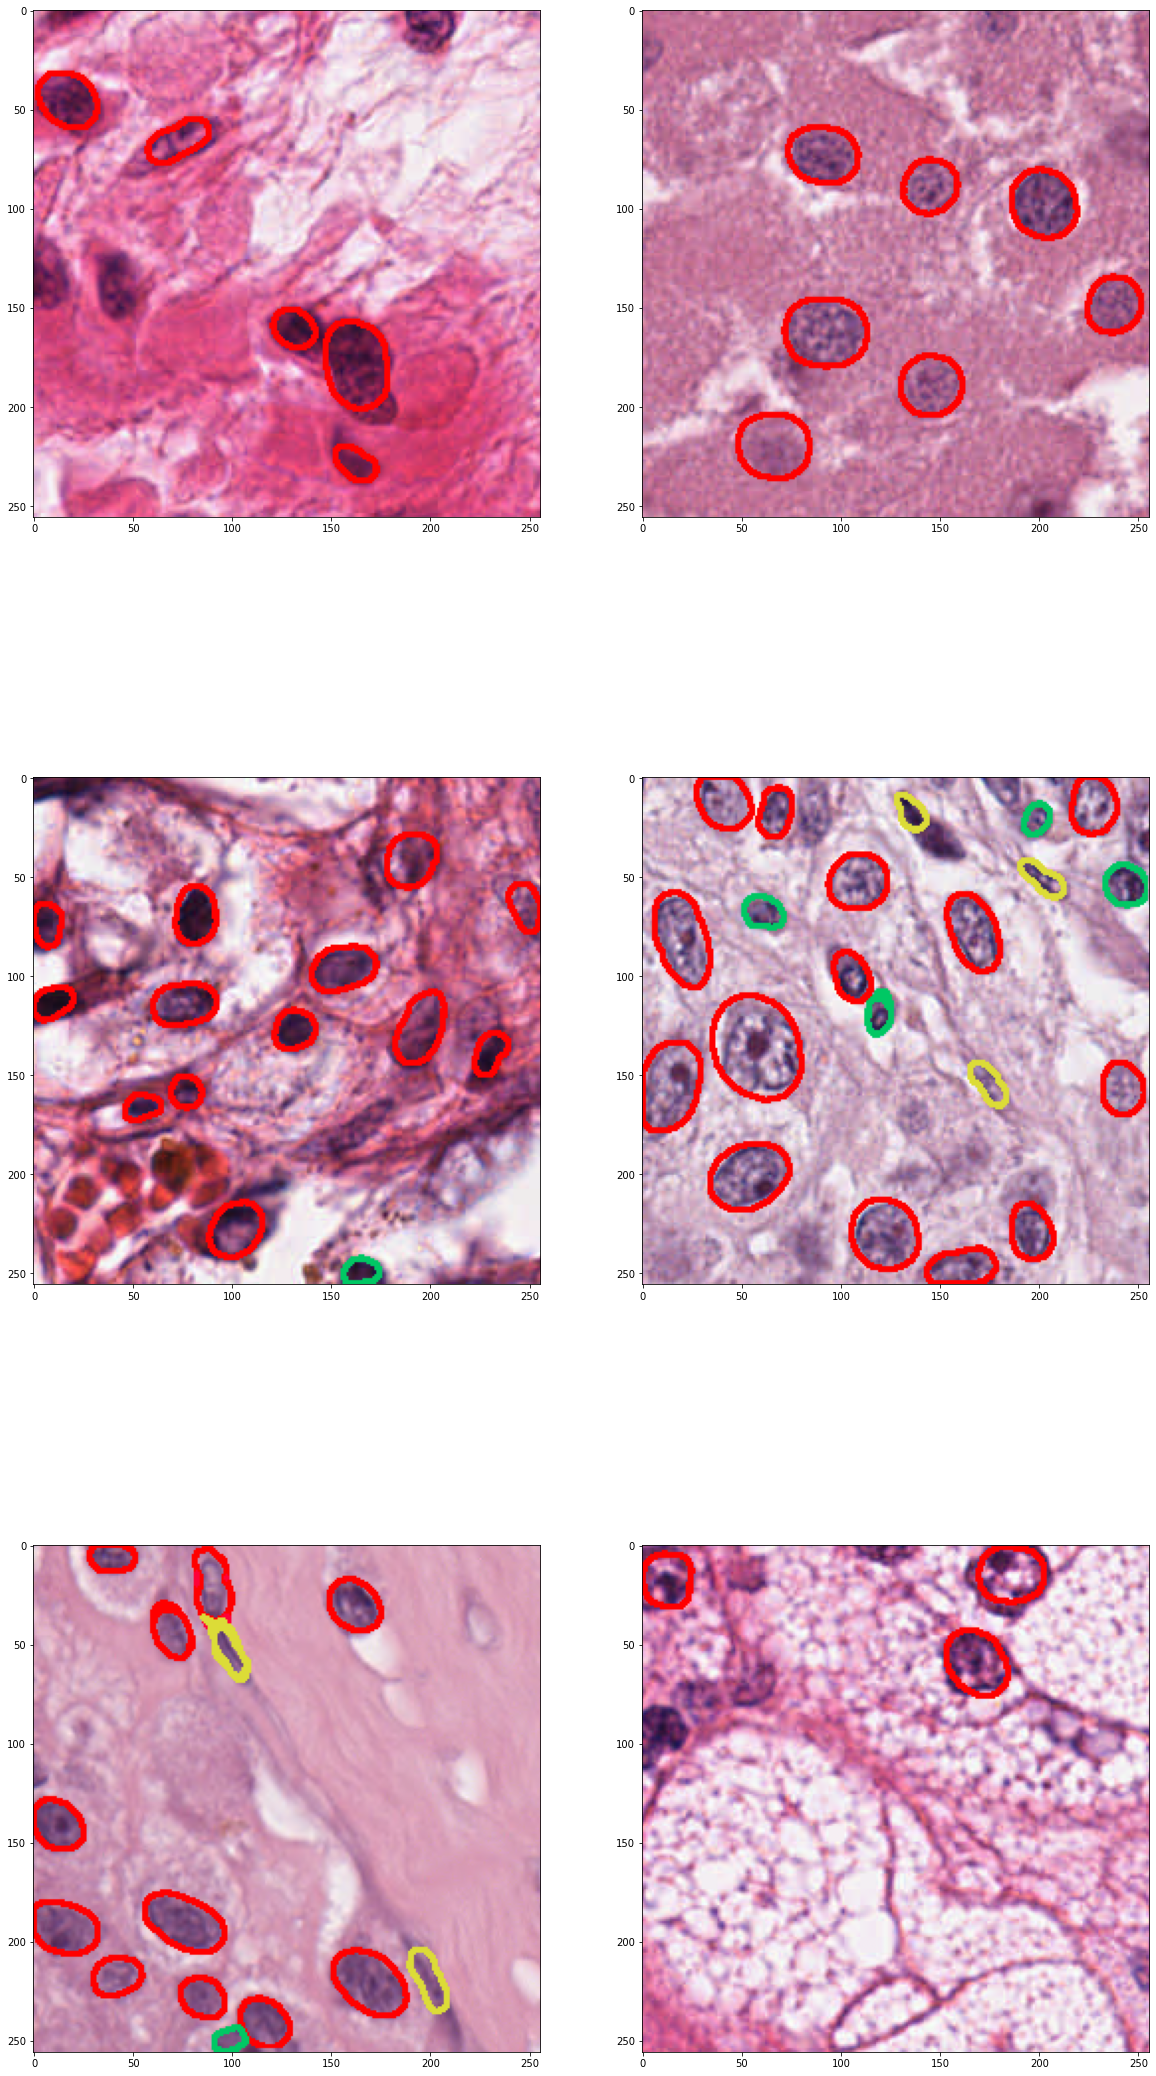

In [67]:
import numpy as np

fig, ax = plt.subplots(3, 2, figsize=(20, 40))
ax = ax.flatten()
ixs = np.random.choice(50, 6, replace=False)

for i, ix in enumerate(ixs):
    samples = list(inferer.out_masks.keys())
    masks = inferer.out_masks[samples[ix]]
    inter = inferer.soft_masks[samples[ix]]

    img_path = save_dir / "test" / f"images/{samples[ix]}.png"
    img = csmp.utils.FileHandler.read_img(img_path)
    cont = csmp.utils.draw_thing_contours(masks["inst"], img, masks["type"])
    ax[i].imshow(cont)